# 1 Create a Relational Model in SQLite

In [125]:
from peewee import *
#from flask import flash 
from datetime import date, timedelta, datetime
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import json
import yaml
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects

# persist information
db = SqliteDatabase('assets.db')

class BaseModel(Model):
    class Meta:
        database = db

class Run(BaseModel): # This model uses the "assets.db" database.
    timestamp = DateTimeField(unique=True)
    symbol = CharField()
    id = AutoField()

class Price(BaseModel): # This model uses the "assets.db" database.
    datetime = DateTimeField(unique=True)
    volume_24 = FloatField()
    price = FloatField()
    runid = ForeignKeyField(Run, backref='prices')
         
# By default, Peewee includes an IF NOT EXISTS clause when creating tables. 
def create_tables():
    with db:
        db.create_tables([Price])
        db.create_tables([Run])

def drop_tables():
    with db:
        db.drop_tables([Price])
        db.drop_tables([Run])
        
create_tables()

#drop_tables()    

# 2 Query the API and Return Price Data as Stream

In [126]:
symbol='BTCUSD'
query_interval = 5 # in seconds
query_number = 200 # the number of queries after which the API stops

# load the API key from our local file
with open(r'C:/Users/Flo/relataly-public-python-tutorials/coinmarketcap.yml') as file:
    apikey = yaml.load(file, Loader=yaml.FullLoader)['key']

# Define some essential API parameters
# Coinmarketcap API for latest market ticker quotes and averages for cryptocurrencies and exchanges.
# https://coinmarketcap.com/api/documentation/v1/#operation/getV1CryptocurrencyListingsLatest
url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
parameters = {
  'start':'1',
  'limit':'2',
  'convert':'USD'
}
headers = {
  'Accepts': 'application/json',
  'X-CMC_PRO_API_KEY': apikey,
}

session = Session()
session.headers.update(headers)

# create a new run and save it to our local SQLite DB
run_timestamp = datetime.now()
run = Run(symbol=symbol, timestamp = run_timestamp)
run.save()
current_run_id = run.id 
print(f'run_id: {current_run_id} - timestamp: {run_timestamp} - interval: {query_interval} - number of queries: {query_number}')

# query the coinmarketcap API every x seconds
for s in range(0, query_number):
    try:
        response = session.get(url, params=parameters)
        data = json.loads(response.text)
        #print(data)
        
        # response - quote
        data_quote = data['data'][0]['quote']['USD']
        price = np.round(data_quote['price'], 1) # the price
        volume_24 = np.round(data_quote['volume_24h'], 1) # the volume in the last 24 hours
        
        # response - status
        data_status = data['status']
        api_timestamp = data_status['timestamp'] # the timestamp of the pricepoint
        api_credits = data_status['credit_count'] # the number of credits spent on the last request
        
        # create a new pricepoint and save it to the SQLite db
        new_pricepoint = Price(datetime=api_timestamp, price=price, volume_24=volume_24, runid=current_run_id)
        id = new_pricepoint.save()

        # display what we have just saved
        print(f'request number: {s} - added {price} at {api_timestamp} - 24 hour volume: {volume_24} - credits used: {api_credits}')      

    except (ConnectionError, Timeout, TooManyRedirects) as e:
        print(e)
    time.sleep(query_interval)
print('finished')

run_id: 13 - timestamp: 2021-04-25 02:01:57.558206 - interval: 5 - number of queries: 200
request number: 0 - added 50119.3 at 2021-04-25T00:01:57.379Z - 24 hour volume: 48446424742.4 - credits used: 1
request number: 1 - added 50119.3 at 2021-04-25T00:02:02.561Z - 24 hour volume: 48446424742.4 - credits used: 1
request number: 2 - added 50119.3 at 2021-04-25T00:02:07.742Z - 24 hour volume: 48446424742.4 - credits used: 1
request number: 3 - added 50119.3 at 2021-04-25T00:02:12.917Z - 24 hour volume: 48446424742.4 - credits used: 1
request number: 4 - added 50115.2 at 2021-04-25T00:02:18.109Z - 24 hour volume: 48402342791.0 - credits used: 1
request number: 5 - added 50115.2 at 2021-04-25T00:02:23.692Z - 24 hour volume: 48402342791.0 - credits used: 1
request number: 6 - added 50115.2 at 2021-04-25T00:02:28.958Z - 24 hour volume: 48402342791.0 - credits used: 1
request number: 7 - added 50115.2 at 2021-04-25T00:02:34.145Z - 24 hour volume: 48402342791.0 - credits used: 1
request number

request number: 72 - added 50141.4 at 2021-04-25T00:08:12.568Z - 24 hour volume: 48363604568.0 - credits used: 1
request number: 73 - added 50108.0 at 2021-04-25T00:08:17.738Z - 24 hour volume: 48358831678.4 - credits used: 1
request number: 74 - added 50108.0 at 2021-04-25T00:08:22.900Z - 24 hour volume: 48358831678.4 - credits used: 1
request number: 75 - added 50108.0 at 2021-04-25T00:08:28.080Z - 24 hour volume: 48358831678.4 - credits used: 1
request number: 76 - added 50108.0 at 2021-04-25T00:08:33.510Z - 24 hour volume: 48358831678.4 - credits used: 1
request number: 77 - added 50108.0 at 2021-04-25T00:08:38.707Z - 24 hour volume: 48358831678.4 - credits used: 1
request number: 78 - added 50108.0 at 2021-04-25T00:08:43.884Z - 24 hour volume: 48358831678.4 - credits used: 1
request number: 79 - added 50108.0 at 2021-04-25T00:08:49.069Z - 24 hour volume: 48358831678.4 - credits used: 1
request number: 80 - added 50108.0 at 2021-04-25T00:08:54.231Z - 24 hour volume: 48358831678.4 -

request number: 145 - added 50178.3 at 2021-04-25T00:14:33.472Z - 24 hour volume: 48334036108.0 - credits used: 1
request number: 146 - added 50178.3 at 2021-04-25T00:14:38.657Z - 24 hour volume: 48334036108.0 - credits used: 1
request number: 147 - added 50178.3 at 2021-04-25T00:14:43.828Z - 24 hour volume: 48334036108.0 - credits used: 1
request number: 148 - added 50178.3 at 2021-04-25T00:14:49.014Z - 24 hour volume: 48334036108.0 - credits used: 1
request number: 149 - added 50178.3 at 2021-04-25T00:14:54.197Z - 24 hour volume: 48334036108.0 - credits used: 1
request number: 150 - added 50178.3 at 2021-04-25T00:14:59.406Z - 24 hour volume: 48334036108.0 - credits used: 1
request number: 151 - added 50178.3 at 2021-04-25T00:15:11.119Z - 24 hour volume: 48334036108.0 - credits used: 1
request number: 152 - added 50200.6 at 2021-04-25T00:15:16.563Z - 24 hour volume: 48332291790.5 - credits used: 1
request number: 153 - added 50200.6 at 2021-04-25T00:15:22.013Z - 24 hour volume: 483322

# 3 Query and Plot the Data

In [47]:
query = Run.select().where(Run.id==current_run_id)
run_overview = pd.DataFrame(list(query.dicts()))
run_overview

,id,timestamp,symbol
0,10,2021-04-24 23:57:24.758231,BTCUSD


      id                  datetime     volume_24    price  runid
0    269  2021-04-25T00:01:57.379Z  4.844642e+10  50119.3     13
1    270  2021-04-25T00:02:02.561Z  4.844642e+10  50119.3     13
2    271  2021-04-25T00:02:07.742Z  4.844642e+10  50119.3     13
3    272  2021-04-25T00:02:12.917Z  4.844642e+10  50119.3     13
4    273  2021-04-25T00:02:18.109Z  4.840234e+10  50115.2     13
..   ...                       ...           ...      ...    ...
195  464  2021-04-25T00:19:12.711Z  4.833238e+10  50264.6     13
196  465  2021-04-25T00:19:18.148Z  4.836642e+10  50311.2     13
197  466  2021-04-25T00:19:23.328Z  4.836642e+10  50311.2     13
198  467  2021-04-25T00:19:28.750Z  4.836642e+10  50311.2     13
199  468  2021-04-25T00:19:33.919Z  4.836642e+10  50311.2     13

[200 rows x 5 columns]


(array([737905.00347222, 737905.00694444, 737905.01041667, 737905.01388889]),
 <a list of 4 Text xticklabel objects>)

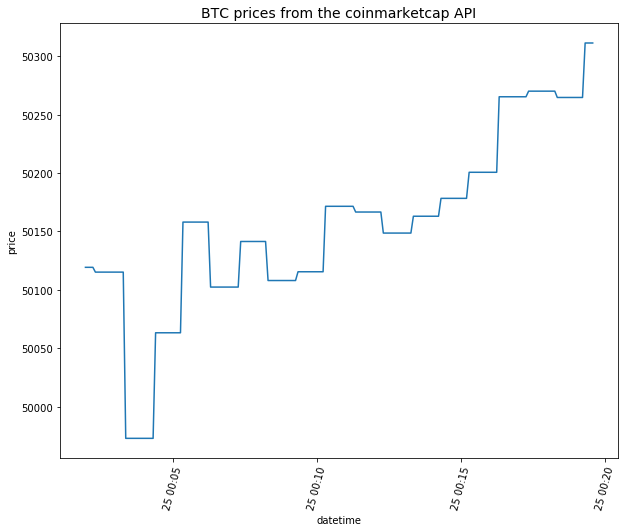

In [127]:
query = Price.select().where(Price.runid==current_run_id)
df_prices = pd.DataFrame(list(query.dicts()))
print(df_prices)

from pandas.plotting import register_matplotlib_converters
import matplotlib.dates as mdates
register_matplotlib_converters()
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('BTC prices from the coinmarketcap API', fontsize=14)
datetimes = pd.to_datetime(df_prices['datetime'])

sns.lineplot(data=df_prices, x=datetimes, y="price")
#ax.set_xlim([df_prices['datetime'].min(),df_prices['datetime'].max()])
#ax.xaxis.set_major_locator(mdates.MinuteLocator())
plt.xticks(rotation=75)